### 소 거래 최적 낙찰가 예측 모델 구현

- 평가지표 = R2, RMSE
- 성별 = 암소:0, 수소:1
- 종류 = 큰소:0, 혈통우:1, 일반우:2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import all_estimators
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

##### 1. 데이터 로딩과 전처리

In [3]:
df = pd.read_csv('../data/cow_data.csv')
df = df.loc[:,['성별','중량','최저가','낙찰가','결격사유 여부','종류']]

df['성별_n'] = df['성별'].apply(lambda x:0 if x == '암' else 1)
df['종류_n'] = df['종류'].apply(lambda x:0 if x == '큰소' else (1 if x == '혈통우' else 2))

df['성별_n'] = df['성별_n'].astype('category')
df['종류_n'] = df['종류_n'].astype('category')
df['결격사유 여부'] = df['결격사유 여부'].astype('category')

df

,성별,중량,최저가,낙찰가,결격사유 여부,종류,성별_n,종류_n
0,암,580,360,363,1,큰소,0,0
1,암,460,320,353,0,큰소,0,0
2,암,340,400,471,1,큰소,0,0
3,암,380,400,432,1,큰소,0,0
4,암,550,650,766,0,큰소,0,0
...,...,...,...,...,...,...,...,...
17443,암,635,970,11750,0,일반우,0,2
17444,암,620,940,10950,0,일반우,0,2
17445,암,614,1100,13500,0,일반우,0,2
17446,암,569,900,9450,0,일반우,0,2


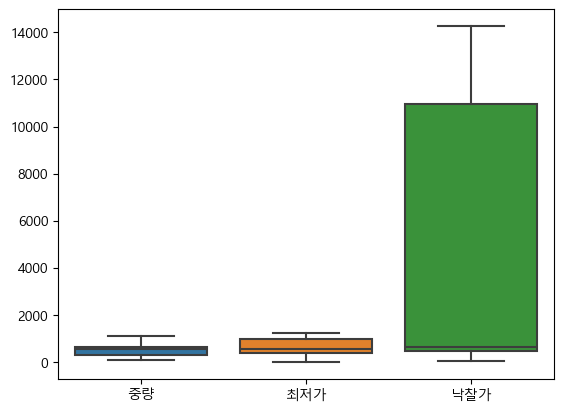

In [4]:
plt.rc('font', family='Malgun Gothic')
sns.boxplot(df)
plt.show()

In [5]:
df['성별'].value_counts(), df['종류'].value_counts()

(암    14487
 수     2961
 Name: 성별, dtype: int64,
 일반우    7655
 큰소     5458
 혈통우    4335
 Name: 종류, dtype: int64)

- 결측치 확인

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17448 entries, 0 to 17447
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   성별       17448 non-null  object  
 1   중량       17448 non-null  int64   
 2   최저가      17448 non-null  int64   
 3   낙찰가      17448 non-null  int64   
 4   결격사유 여부  17448 non-null  category
 5   종류       17448 non-null  object  
 6   성별_n     17448 non-null  category
 7   종류_n     17448 non-null  category
dtypes: category(3), int64(3), object(2)
memory usage: 733.2+ KB


- 이상치 확인
1) 최저가 컬럼의 0값 제거
2) 낙찰가 컬럼 단위 통일
3) 큰소-수소 데이터 드롭 ( 암소인데 수소로 잘못 등록되어 있음 )

In [7]:
df.describe()

,중량,최저가,낙찰가
count,17448.000000,17448.000000,17448.000000
mean,499.346114,669.672513,5122.761692
std,173.233963,297.998572,5350.663271
min,110.000000,0.000000,57.000000
25%,310.000000,410.000000,460.000000
50%,545.000000,560.000000,636.000000
75%,634.000000,980.000000,10950.000000
max,1114.000000,1250.000000,14250.000000


In [8]:
df['최저가'].sort_values()

5243        0
5081        0
8453       60
8483       70
8518       70
         ... 
17378    1170
15793    1180
15443    1180
17108    1200
13685    1250
Name: 최저가, Length: 17448, dtype: int64

In [9]:
df = df[df['최저가']!=0]

In [10]:
df['낙찰가'] = df['낙찰가'].apply(lambda x: int(x / 10) if x > 2000 else int(x))

C:\Users\KDP-13\AppData\Local\Temp\ipykernel_6172\2626693971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['낙찰가'] = df['낙찰가'].apply(lambda x: int(x / 10) if x > 2000 else int(x))


In [11]:
df = df[~((df['성별'] == '수') & (df['종류'] == '큰소'))]

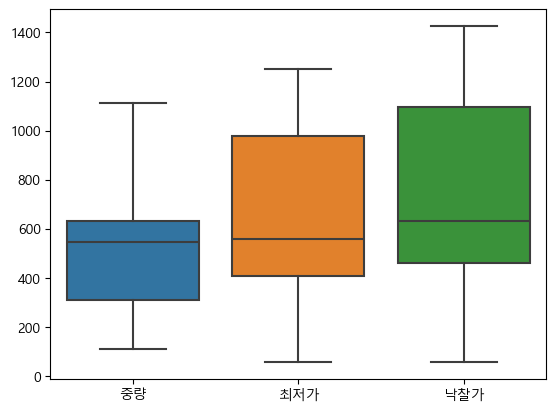

In [12]:
sns.boxplot(df)
plt.show()

- 상관계수 확인

In [13]:
df.corr(numeric_only=True)['낙찰가']

중량     0.743888
최저가    0.982829
낙찰가    1.000000
Name: 낙찰가, dtype: float64

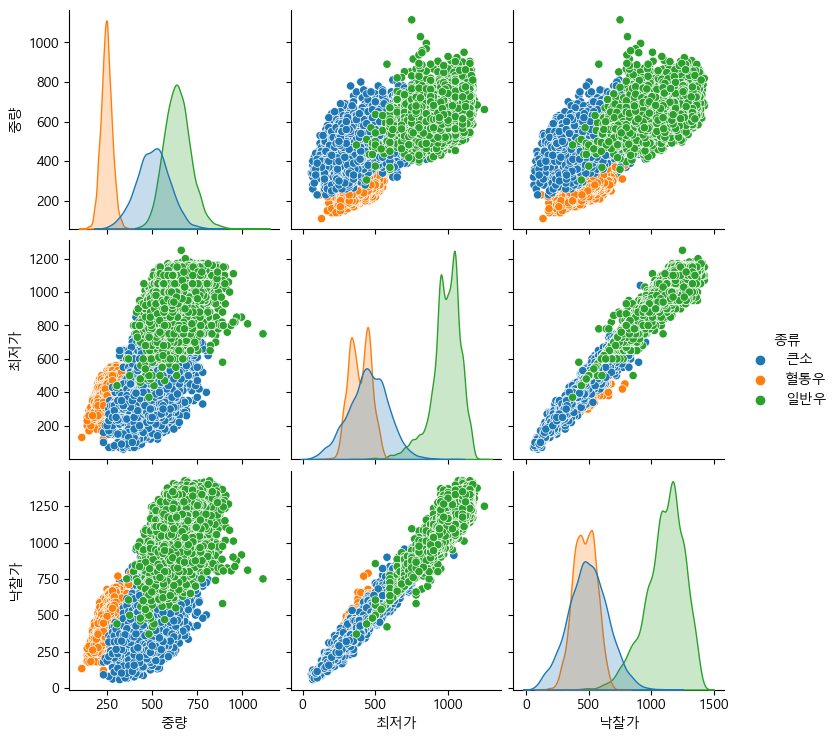

In [14]:
plt.rc('font', family='Malgun Gothic')
sns.pairplot(df, hue='종류')
plt.show()

- 데이터의 크기가 종류별로 서로 비슷하므로, 업샘플링-다운샘플링 진행하지 않고 모델 구현
- 차후 모델 성능이 나오지 않을 시에 고려함

In [15]:
df['종류'].value_counts()

일반우    7655
큰소     5432
혈통우    4333
Name: 종류, dtype: int64

##### 2. 모델 구현

- 주요 분석 방법: 회귀분석
- 세부 분석 방법: 랜덤포레스트, GBM 알고리즘
- 사용 피처 - 타겟
    1) 중량, 최저가 - 낙찰가
    2) 중량 - 낙찰가 <br><br>
- 평가 지표: $R^2$, RMSE

1) 중량, 최저가 - 낙찰가 모델 구현

In [14]:
# # 피처, 타겟 데이터 분리
# feature = df[['중량','최저가']].copy()
# target = df['낙찰가']

# # 데이터 스케일링
# scaler = StandardScaler()
# scaler.fit(feature)
# feature_scaled = scaler.transform(feature)

# # 회귀 모델 모두 돌린 결과 반환
# all_models = all_estimators(type_filter='regressor')

# result = []

# for name, model_ in all_models:
#     try:
#         model = model_()
#         if 'logistic' in name or 'SDG' in name or 'MLP' in name:
#             model.set_params(max_iter=1000)
#         elif 'sv' in name:
#             model.set_params(max_iter=10000, dual='auto')
        
#         model.fit(feature_scaled, target)
#         score = model.score(feature_scaled, target)
#         result.append((name, round(score,3)))
#     except Exception:
#         pass

# print(sorted(result, key=lambda x : x[1], reverse=True))

- 최저가 컬럼의 상관계수가 너무 높아서 과대적합 문제 발생
- 따라서 중량-낙찰가를 대상으로 모델 구현 

In [15]:
# # 피처, 타겟 데이터 분리
# feature = np.array(df[['중량']])
# target = np.array(df['낙찰가'])

# # 데이터 스케일링
# scaler = StandardScaler()
# scaler.fit(feature)
# feature_scaled = scaler.transform(feature)


# # 회귀 모델 모두 돌린 결과 반환
# all_models = all_estimators(type_filter='regressor')

# result = []

# for name, model_ in all_models:
#     try:
#         model = model_()
#         if 'logistic' in name or 'SDG' in name or 'MLP' in name:
#             model.set_params(max_iter=1000)
#         elif 'sv' in name:
#             model.set_params(max_iter=10000, dual='auto')
        
#         model.fit(feature_scaled, target)
#         score = model.score(feature_scaled, target)
#         result.append((name, round(score,3)))
#     except Exception:
#         pass

# print(sorted(result, key=lambda x : x[1], reverse=True))

- 랜덤포레스트로 회귀 모형 구현, 최적 파라미터 설정

In [16]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# # 훈련-테스트 = 8:2, 훈련-검증 = 9:1
# train_X, test_X, train_y, test_y = train_test_split(feature_scaled, target, test_size=0.2, random_state=0)
# trn_X, val_X, trn_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=0)

# # 최적의 모델 찾기
# params = {'max_depth':[20,30,40,50,60,70],
#           'min_samples_leaf':[1,2,3,4,5],
#           'min_samples_split':[1,2,3,4,5]}

# reg = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
# grid_cv = GridSearchCV(reg, param_grid=params, cv=3, n_jobs=-1)
# grid_cv.fit(trn_X, trn_y)

# grid_cv.best_params_, grid_cv.best_score_

In [17]:
# # 모델 생성
# forest_reg = RandomForestRegressor(n_estimators=100, 
#                                    max_depth=20, 
#                                    min_samples_split=5,
#                                    min_samples_leaf=2, 
#                                    random_state=0)
# forest_reg.fit(trn_X, trn_y)

# rmse = -np.mean(cross_val_score(forest_reg, test_X, test_y, scoring='neg_root_mean_squared_error', cv=3))


# print(f'train_score = {forest_reg.score(trn_X, trn_y)}\nval_score = {forest_reg.score(val_X, val_y)}')
# print(f'RMSE = {rmse}')

In [18]:
# from sklearn.metrics import r2_score

# # 모델 평가
# pre_y = forest_reg.predict(test_X)
# r2_score(test_y, pre_y)

##### pycaret 패키지 활용

- 최저가 컬럼 제외
- 종류 컬럼 제외하고 최적 파라미터로 튜닝하면 위와 같은 수준의 결과 도출
- 따라서 종류 컬럼 추가하여 분석

In [19]:
# 분류일때는 classification, 회귀일때는 regression
from pycaret.regression import *

df2 = df.drop(['최저가','종류'],axis=1)
train, test = train_test_split(df2, test_size=0.8, random_state=0)

# r ==> pycaret 할 '공간'을 지정해줌
r = RegressionExperiment()
r.setup(data=train, target='낙찰가', session_id=0, normalize='zscore')  # sessioin_id  => randomstate임 !! 
r.compare_models()  # 모델 비교 함 해주고

# 결과  => 	MAE	MSE	RMSE 낮을 수록 좋음. R2는 신뢰도? 얼마나 믿을수 있는가 생각.(1에 가까울 수록 좋은데 컬럼수 높아지면 같이 높아지기 때문에 단정 ㄴㄴ)
# 결과 좋은 순으로 촥촥 뽑아줌

,Description,Value
0,Session id,0
1,Target,낙찰가
2,Target type,Regression
3,Original data shape,"(3484, 6)"
4,Transformed data shape,"(3484, 8)"
5,Transformed train set shape,"(2438, 8)"
6,Transformed test set shape,"(1046, 8)"
7,Ordinal features,3
8,Numeric features,1
9,Categorical features,4


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,90.6182,14779.0582,121.3603,0.8724,0.2174,0.1605,0.0520
lightgbm,Light Gradient Boosting Machine,93.1131,15440.9037,124.1143,0.8666,0.2200,0.1635,0.1110
lasso,Lasso Regression,95.5132,15902.2744,125.9010,0.8623,0.2230,0.1699,0.0240
ridge,Ridge Regression,95.2838,15898.8475,125.8758,0.8623,0.2223,0.1690,0.0240
br,Bayesian Ridge,95.2874,15898.8587,125.8761,0.8623,0.2223,0.1690,0.0230
lr,Linear Regression,95.4670,15908.9046,125.9114,0.8623,0.2227,0.1696,0.0230
llar,Lasso Least Angle Regression,95.6614,15983.0842,126.2047,0.8616,0.2229,0.1697,0.0240
lar,Least Angle Regression,95.4714,15990.4581,126.2191,0.8615,0.2223,0.1688,0.0240
huber,Huber Regressor,93.9318,16086.1873,126.5496,0.8606,0.2229,0.1685,0.0270
par,Passive Aggressive Regressor,95.1860,16314.6349,127.4338,0.8586,0.2265,0.1733,0.0240


GradientBoostingRegressor(random_state=0)

In [18]:
# 젤 좋게 나온거 'gbr' 선택해서 r 공간에서 model 만들어줌
gbr_reg = r.create_model('gbr')
# 결과 => k fold 까지 해서 (기본 10번) 평균 값 보여줌

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.4264,15562.6317,124.7503,0.8724,0.2277,0.1629
1,77.9761,10945.1615,104.6191,0.9106,0.1835,0.1334
2,89.7426,14593.5314,120.8037,0.8634,0.2124,0.1562
3,84.7663,12793.4123,113.1080,0.8820,0.2021,0.1444
4,97.4785,17220.0755,131.2253,0.8577,0.2115,0.1584
5,96.5523,15770.7796,125.5818,0.8730,0.2074,0.1590
6,87.2984,14812.1513,121.7052,0.8692,0.2221,0.1616
7,91.7777,15619.7256,124.9789,0.8583,0.2372,0.1730
8,93.7899,14671.3617,121.1254,0.8772,0.2340,0.1762


In [21]:
# tune_model => 하이퍼 파라미터 튜닝 하는거 (근데 파이캐럿에서는 내가 하나하나 설정 안해도 됨.)
tuned_gbr_reg, tuner = r.tune_model(gbr_reg, optimize='RMSE', return_tuner=True)
# tuned_gbr_reg: 모델 튜닝 후 최적의 하이퍼파라미터가 적용된 모델을 저장. 즉, 이 모델은 튜닝된 모델로, 최적의 성능을 보일 것으로 예상
# tuner: 튜닝 과정을 관리하는 튜니러 객체를 저장. return_tuner=True 매개변수로 설정되어 있기 때문에, tuner 변수에 이 튜너 객체가 반환
# tuned_gbr_reg는 최종 튜닝된 모델을 저장하고, tuner는 모델 튜닝 과정을 관리하고 향후 튜닝 작업을 조절하기 위한 객체를 저장

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,125.0988,33608.1277,183.3252,0.7245,0.2919,0.2085
1,113.4996,25738.6560,160.4327,0.7897,0.2542,0.1876
2,114.9143,26303.8085,162.1845,0.7538,0.2558,0.1918
3,102.5782,19927.4782,141.1647,0.8162,0.2419,0.1694
4,121.4758,28725.6602,169.4865,0.7627,0.2550,0.1938
5,131.9560,32394.1684,179.9838,0.7392,0.2563,0.1983
6,126.6719,33235.1500,182.3051,0.7065,0.2853,0.2263
7,119.5582,28063.1696,167.5207,0.7455,0.2851,0.2109
8,113.3493,23640.2353,153.7538,0.8021,0.2707,0.2045


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [22]:
print(type(tuned_gbr_reg))
print(tuned_gbr_reg)

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
GradientBoostingRegressor(learning_rate=0.05, max_depth=9, max_features=1.0,
                          min_impurity_decrease=0.001, min_samples_split=4,
                          n_estimators=260, random_state=0)


In [23]:
print(type(tuner))
print(tuner)

<class 'sklearn.model_selection._search.RandomizedSearchCV'>
RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(memory=FastMemory(location=C:\Users\a\AppData\Local\Temp\joblib),
                                      steps=[('numerical_imputer',
                                              TransformerWrapper(include=['중량',
                                                                          '결격사유 '
                                                                          '여부'],
                                                                 transformer=SimpleImputer())),
                                             ('categorical_imputer',
                                              TransformerWrapper(include=['성별'],
                                                                 transformer=SimpleImputer(strateg...
                                        'actual_estimator__min_samples_split': [2,
                  

In [24]:
sorted(list(zip(tuned_gbr_reg.feature_names_in_, tuned_gbr_reg.feature_importances_)), key=lambda x:x[1], reverse=True)

[('중량', 0.9729259401831278),
 ('결격사유 여부', 0.017922883239709284),
 ('성별', 0.009151176577162946)]

- 종류 데이터 추가하여 다시 최적화

In [25]:
from pycaret.regression import *

df3 = df.drop('최저가',axis=1)

train, test = train_test_split(df3, test_size=0.8, random_state=0)

r2 = RegressionExperiment()
r2.setup(data=train, target='낙찰가', session_id=0, normalize='zscore')

gbr_reg2 = r2.create_model('gbr')
tuned_gbr_reg2, tuner2 = r2.tune_model(gbr_reg2, optimize='RMSE', return_tuner=True)

print(type(tuned_gbr_reg2))
print(tuned_gbr_reg2)

,Description,Value
0,Session id,0
1,Target,낙찰가
2,Target type,Regression
3,Original data shape,"(3484, 5)"
4,Transformed data shape,"(3484, 7)"
5,Transformed train set shape,"(2438, 7)"
6,Transformed test set shape,"(1046, 7)"
7,Ordinal features,1
8,Numeric features,2
9,Categorical features,2


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.4264,15562.6317,124.7503,0.8724,0.2277,0.1629
1,77.9761,10945.1615,104.6191,0.9106,0.1835,0.1334
2,89.7426,14593.5314,120.8037,0.8634,0.2124,0.1562
3,84.7663,12793.4123,113.1080,0.8820,0.2021,0.1444
4,97.4785,17220.0755,131.2253,0.8577,0.2115,0.1584
5,96.5523,15770.7796,125.5818,0.8730,0.2074,0.1590
6,87.2984,14812.1513,121.7052,0.8692,0.2221,0.1616
7,91.7777,15619.7256,124.9789,0.8583,0.2372,0.1730
8,93.7899,14671.3617,121.1254,0.8772,0.2340,0.1762


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,94.6093,16036.8728,126.6368,0.8686,0.2383,0.1743
1,84.8962,12260.3858,110.7266,0.8998,0.1907,0.1445
2,101.4235,17640.3136,132.8168,0.8349,0.2330,0.1785
3,91.3563,14465.2137,120.2714,0.8666,0.2150,0.1595
4,101.3247,17324.9870,131.6244,0.8569,0.2144,0.1662
5,100.3603,16025.2352,126.5908,0.8710,0.2152,0.1684
6,89.8900,15287.6493,123.6432,0.8650,0.2308,0.1706
7,97.4604,16974.1279,130.2848,0.8461,0.2520,0.1881
8,98.1781,15681.2922,125.2250,0.8687,0.2373,0.1829


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
GradientBoostingRegressor(random_state=0)


In [26]:
r2.evaluate_model(tuned_gbr_reg2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

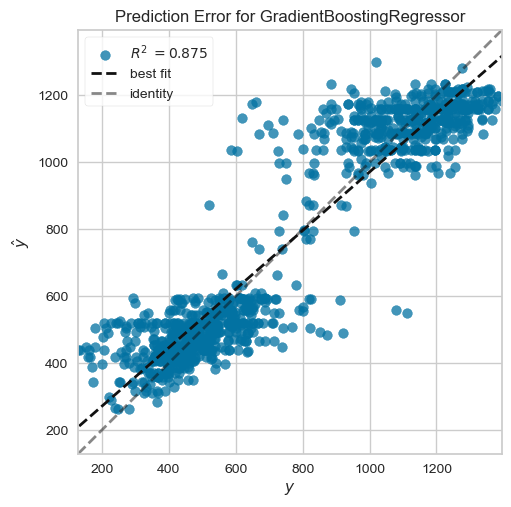

In [27]:
r2.plot_model(tuned_gbr_reg2, plot='error')

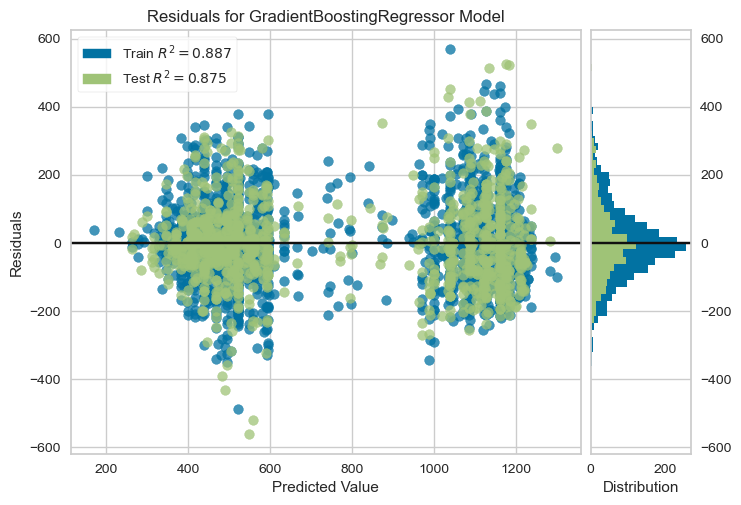

In [28]:
r2.plot_model(tuned_gbr_reg2, plot='residuals')

In [29]:
final_model = r2.finalize_model(tuned_gbr_reg2)

r2.predict_model(final_model, data = train)
r2.predict_model(final_model, data = test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,86.1272,13516.0777,116.2587,0.8847,0.2089,0.1518


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,92.4586,15323.7730,123.7892,0.8687,0.2179,0.1613


,성별,중량,결격사유 여부,종류,낙찰가,prediction_label
16576,암,702,0,일반우,1330,1177.478745
9118,암,530,1,큰소,546,439.797304
14263,암,686,0,일반우,970,1162.491859
13798,암,839,0,일반우,1235,1196.600523
12470,암,642,0,일반우,1165,1122.700181
...,...,...,...,...,...,...
842,암,520,0,큰소,550,504.693014
9721,암,440,0,큰소,551,436.983990
17142,암,717,0,일반우,1285,1178.789791
11544,암,598,0,일반우,830,1076.398215


- 혹시 스케일링 하고싶다면..

In [30]:
prep_pipe = r2.get_config('pipeline')
scaled_test = prep_pipe.transform(test)
scaled_test

,성별,중량,낙찰가,결격사유 여부,종류_일반우,종류_큰소,종류_혈통우
16576,0.448973,1.181958,1330,-0.362384,1.169184,-0.682660,-0.592193
9118,0.448973,0.194994,546,2.759500,-0.855298,1.464857,-0.592193
14263,0.448973,1.090147,970,-0.362384,1.169184,-0.682660,-0.592193
13798,0.448973,1.968086,1235,-0.362384,1.169184,-0.682660,-0.592193
12470,0.448973,0.837668,1165,-0.362384,1.169184,-0.682660,-0.592193
...,...,...,...,...,...,...,...
842,0.448973,0.137612,550,-0.362384,-0.855298,1.464857,-0.592193
9721,0.448973,-0.321441,551,-0.362384,-0.855298,1.464857,-0.592193
17142,0.448973,1.268030,1285,-0.362384,1.169184,-0.682660,-0.592193
11544,0.448973,0.585189,830,-0.362384,1.169184,-0.682660,-0.592193


In [31]:
sorted(list(zip(tuned_gbr_reg2.feature_names_in_, tuned_gbr_reg2.feature_importances_)), key=lambda x:x[1], reverse=True)

[('종류_일반우', 0.9329392370383172),
 ('중량', 0.052782988106303684),
 ('성별', 0.011164928285311399),
 ('결격사유 여부', 0.002130156388110004),
 ('종류_큰소', 0.0006370796417244292),
 ('종류_혈통우', 0.0003456105402332409)]

- 모든 컬럼 추가하여 다시 분석

In [32]:
from pycaret.regression import *

train, test = train_test_split(df, test_size=0.8, random_state=0)

r3 = RegressionExperiment()
r3.setup(data=train, target='낙찰가', session_id=0, normalize='zscore')
r3.compare_models()

,Description,Value
0,Session id,0
1,Target,낙찰가
2,Target type,Regression
3,Original data shape,"(3484, 6)"
4,Transformed data shape,"(3484, 8)"
5,Transformed train set shape,"(2438, 8)"
6,Transformed test set shape,"(1046, 8)"
7,Ordinal features,1
8,Numeric features,3
9,Categorical features,2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,45.5241,3517.3054,59.2510,0.9697,0.0866,0.0668,0.2700
ridge,Ridge Regression,47.2791,3676.4691,60.5909,0.9683,0.0940,0.0695,0.2270
br,Bayesian Ridge,47.2784,3676.3000,60.5897,0.9683,0.0946,0.0695,0.2310
huber,Huber Regressor,47.3109,3682.5332,60.6391,0.9683,0.0958,0.0695,0.2280
lr,Linear Regression,47.2776,3676.0974,60.5884,0.9683,0.0946,0.0695,0.2270
llar,Lasso Least Angle Regression,47.4303,3708.2372,60.8428,0.9681,0.0894,0.0692,0.2290
lightgbm,Light Gradient Boosting Machine,46.2714,3695.5204,60.7409,0.9681,0.0905,0.0686,0.2800
lasso,Lasso Regression,47.4317,3708.6068,60.8457,0.9681,0.0894,0.0692,0.2230
lar,Least Angle Regression,47.5823,3730.3925,61.0270,0.9679,0.1129,0.0709,0.2320
par,Passive Aggressive Regressor,48.3464,3840.3108,61.9084,0.9670,0.0960,0.0714,0.2290


GradientBoostingRegressor(random_state=0)

In [33]:
gbr_reg3 = r3.create_model('gbr')
tuned_gbr_reg3 = r3.tune_model(gbr_reg3, optimize='RMSE')

r3.evaluate_model(tuned_gbr_reg3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,47.0340,3901.1561,62.4592,0.9680,0.0895,0.0680
1,44.4223,3395.1759,58.2681,0.9723,0.0830,0.0649
2,43.8383,3177.2779,56.3673,0.9703,0.0826,0.0637
3,44.3867,3422.2045,58.4996,0.9684,0.0835,0.0636
4,45.9525,3435.9380,58.6169,0.9716,0.0839,0.0662
5,50.5945,4224.7907,64.9984,0.9660,0.0908,0.0716
6,43.8266,3399.4951,58.3052,0.9700,0.0899,0.0680
7,43.9153,3350.6984,57.8852,0.9696,0.0910,0.0676
8,48.3779,3681.3495,60.6741,0.9692,0.0910,0.0721


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.3939,4734.9844,68.8112,0.9612,0.1042,0.0778
1,47.1884,3855.4051,62.0919,0.9685,0.0899,0.0701
2,49.2266,4160.7404,64.5038,0.9611,0.0946,0.0731
3,47.3349,3846.7580,62.0222,0.9645,0.0929,0.0694
4,51.4794,4729.3970,68.7706,0.9609,0.0972,0.0746
5,54.6802,4909.4817,70.0677,0.9605,0.1073,0.0802
6,47.1429,3902.5243,62.4702,0.9655,0.0956,0.0732
7,45.6425,3712.8834,60.9334,0.9663,0.0998,0.0731
8,53.2714,4423.8880,66.5123,0.9630,0.1007,0.0806


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:
final_model2 = r3.finalize_model(tuned_gbr_reg3)

r3.predict_model(final_model2, data = train)
r3.predict_model(final_model2, data = test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,42.0031,3019.6983,54.9518,0.9742,0.0798,0.0614


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,44.3144,3335.4756,57.7536,0.9714,0.0828,0.0645


,성별,중량,최저가,결격사유 여부,종류,낙찰가,prediction_label
16576,암,702,1100,0,일반우,1330,1270.423192
9118,암,530,530,1,큰소,546,575.273277
14263,암,686,970,0,일반우,970,1123.363854
13798,암,839,1070,0,일반우,1235,1269.340154
12470,암,642,1040,0,일반우,1165,1192.952556
...,...,...,...,...,...,...,...
842,암,520,530,0,큰소,550,575.273277
9721,암,440,440,0,큰소,551,480.877779
17142,암,717,1100,0,일반우,1285,1277.063956
11544,암,598,830,0,일반우,830,868.881049


In [35]:
sorted(list(zip(tuned_gbr_reg3.feature_names_in_, tuned_gbr_reg3.feature_importances_)), key=lambda x:x[1], reverse=True)

[('최저가', 0.9932705890990501),
 ('중량', 0.004798187790741927),
 ('종류_혈통우', 0.001658144705472757),
 ('결격사유 여부', 0.00014897901589151124),
 ('종류_큰소', 6.279690334724866e-05),
 ('종류_일반우', 5.431865939782885e-05),
 ('성별', 6.9838260986870085e-06)]

- 성별, 결격사유 여부 컬럼 제외

In [47]:
from pycaret.regression import *

df4 = df.drop(['성별','결격사유 여부'],axis=1)

train, test = train_test_split(df4, test_size=0.8, random_state=0)

r4 = RegressionExperiment()
r4.setup(data=train, target='낙찰가', session_id=0, normalize='zscore')
r4.compare_models()

,Description,Value
0,Session id,0
1,Target,낙찰가
2,Target type,Regression
3,Original data shape,"(3484, 4)"
4,Transformed data shape,"(3484, 6)"
5,Transformed train set shape,"(2438, 6)"
6,Transformed test set shape,"(1046, 6)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,45.5521,3523.8294,59.3052,0.9697,0.0865,0.0668,0.2820
lightgbm,Light Gradient Boosting Machine,46.1824,3688.0201,60.6785,0.9682,0.0906,0.0686,0.2900
lar,Least Angle Regression,47.5688,3707.1724,60.8452,0.9681,0.0931,0.0699,0.2530
br,Bayesian Ridge,47.5677,3707.1713,60.8451,0.9681,0.0930,0.0699,0.2490
ridge,Ridge Regression,47.5613,3707.3402,60.8462,0.9681,0.0926,0.0698,0.2710
lr,Linear Regression,47.5754,3708.5122,60.8558,0.9680,0.0930,0.0699,0.5950
huber,Huber Regressor,47.5852,3713.6115,60.8963,0.9680,0.0931,0.0698,0.2610
lasso,Lasso Regression,47.6084,3727.7951,61.0037,0.9679,0.0897,0.0696,0.2540
llar,Lasso Least Angle Regression,47.6062,3727.3201,60.9999,0.9679,0.0897,0.0696,0.2540
par,Passive Aggressive Regressor,48.0818,3800.7732,61.5911,0.9673,0.0921,0.0708,0.2570


In [42]:
gbr_reg4 = r4.create_model('gbr')
tuned_gbr_reg4 = r4.tune_model(gbr_reg4, optimize='RMSE')

r4.evaluate_model(tuned_gbr_reg4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.7093,3815.6158,61.7707,0.9687,0.0890,0.0676
1,44.4374,3401.4953,58.3223,0.9722,0.0830,0.0648
2,43.9746,3214.5275,56.6968,0.9699,0.0823,0.0637
3,44.1733,3359.2985,57.9595,0.9690,0.0827,0.0635
4,45.8690,3448.9626,58.7279,0.9715,0.0842,0.0661
5,50.7834,4276.9468,65.3984,0.9656,0.0908,0.0719
6,44.3826,3494.7369,59.1163,0.9691,0.0904,0.0685
7,43.6465,3314.4299,57.5711,0.9699,0.0909,0.0674
8,48.6471,3724.6052,61.0295,0.9688,0.0907,0.0722


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,54.0655,5083.6309,71.2996,0.9583,0.1049,0.0789
1,44.7828,3664.0238,60.5312,0.9701,0.0859,0.0662
2,47.8970,3841.5714,61.9804,0.9640,0.0899,0.0697
3,47.5859,3937.4285,62.7489,0.9637,0.0890,0.0686
4,50.4150,4351.2694,65.9642,0.9641,0.0960,0.0739
5,51.3315,4475.5097,66.8993,0.9640,0.0948,0.0734
6,49.0003,4098.4865,64.0194,0.9638,0.0995,0.0761
7,48.1930,4172.0949,64.5918,0.9622,0.1034,0.0760
8,54.6242,4671.1458,68.3458,0.9609,0.1061,0.0830


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [43]:
final_model3 = r4.finalize_model(tuned_gbr_reg4)

r4.predict_model(final_model3, data = train)
r4.predict_model(final_model3, data = test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,41.9723,3013.9577,54.8995,0.9743,0.0798,0.0614


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,44.3209,3334.1213,57.7419,0.9714,0.0827,0.0644


,중량,최저가,종류,낙찰가,prediction_label
16576,702,1100,일반우,1330,1271.733569
9118,530,530,큰소,546,575.114158
14263,686,970,일반우,970,1123.790487
13798,839,1070,일반우,1235,1277.421011
12470,642,1040,일반우,1165,1195.049722
...,...,...,...,...,...
842,520,530,큰소,550,575.114158
9721,440,440,큰소,551,481.265988
17142,717,1100,일반우,1285,1276.718040
11544,598,830,일반우,830,868.702404


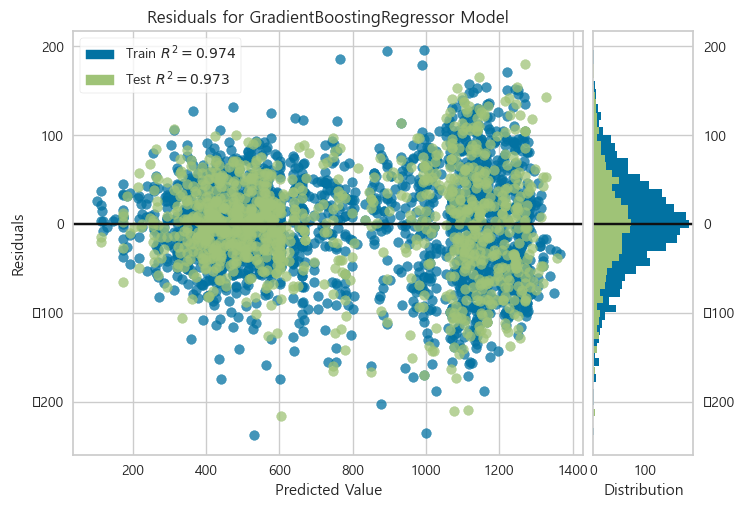

In [69]:
r4.plot_model(tuned_gbr_reg4, plot='residuals')

In [44]:
sorted(list(zip(tuned_gbr_reg4.feature_names_in_, tuned_gbr_reg4.feature_importances_)), key=lambda x:x[1], reverse=True)

[('최저가', 0.9933757048243208),
 ('중량', 0.004860328205928091),
 ('종류_혈통우', 0.001461126763023091),
 ('종류_큰소', 0.00028007927379328793),
 ('종류_일반우', 2.2760932934672422e-05)]